# Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

Данные: **credit_card_default_analysis.csv**

### Критерии
1. Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
2. При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
3. При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость.
4. Выполненное задание необходимо представить в ipython-ноутбука.

## 1. Размер кредитного лимита (LIMIT_BAL). 
В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('datasets/credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
data_0 = data[data.default == 0]
data_1 = data[data.default == 1]

**Построим гистограммы частот**

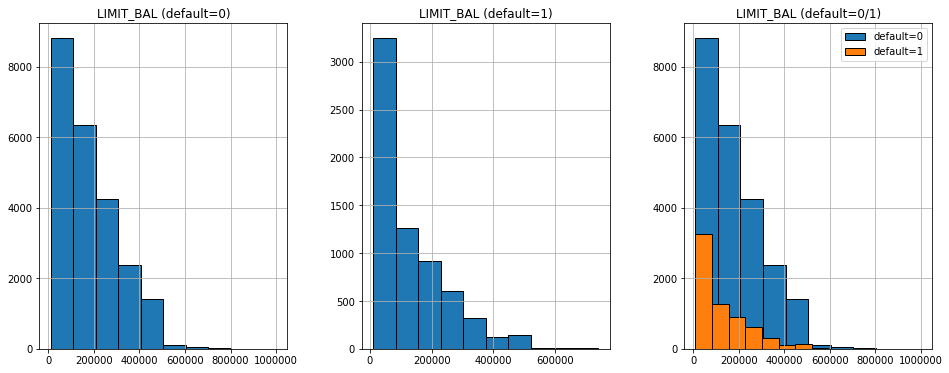

In [4]:
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 3, 1)
data_0.hist(column='LIMIT_BAL', edgecolor='black', ax=ax1)
ax1.set_title('LIMIT_BAL (default=0)')

ax2 = plt.subplot(1, 3, 2)
data_1.hist(column='LIMIT_BAL', edgecolor='black', ax=ax2)
ax2.set_title('LIMIT_BAL (default=1)')

ax3 = plt.subplot(1, 3, 3)
data_0.hist(column='LIMIT_BAL', edgecolor='black', ax=ax3, label='default=0')
data_1.hist(column='LIMIT_BAL', edgecolor='black', ax=ax3, label='default=1')
ax3.legend()
ax3.set_title('LIMIT_BAL (default=0/1)')

plt.show()

По гистограммам можно увидеть, что распределения у нас немного скошенные и для должников размер кредита меньше.

In [5]:
med_0, med_1 = data_0.LIMIT_BAL.median(), data_1.LIMIT_BAL.median()
print('Медиана кредтиного лимита для тех, кто вернул кредит {}'.format(med_0))
print('Медиана кредтиного лимита для тех, кто не вернул кредит {}'.format(med_1))

Медиана кредтиного лимита для тех, кто вернул кредит 150000.0
Медиана кредтиного лимита для тех, кто не вернул кредит 90000.0


**Построим с помощью бутстрепа 95% интервальные оценки для медиан каждого класса**

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
med_scores_0 = list(map(np.median, get_bootstrap_samples(data_0.LIMIT_BAL.values, 1000)))

In [9]:
med_scores_1 = list(map(np.median, get_bootstrap_samples(data_1.LIMIT_BAL.values, 1000)))

In [10]:
print('Доверительный интервал для тех, кто вернул кредит:', stat_intervals(med_scores_0, 0.05))
print('Доверительный интервал для тех, кто не вернул кредит:', stat_intervals(med_scores_1, 0.05))

Доверительный интервал для тех, кто вернул кредит: [150000. 150000.]
Доверительный интервал для тех, кто не вернул кредит: [80000. 90000.]


**Построим доверительный интервал для разности медиан**

In [11]:
delta_med_scores = list(map(lambda x: x[0] - x[1], zip(med_scores_0, med_scores_1)))
stat_intervals(delta_med_scores, 0.05)

array([60000., 70000.])

Доверительный интервал не содержит нуля, следовательно медианы выборок не совпадают

**Проверим гипотезу о равенстве распределений с помощью критерия Манна-Уитни:**  

$H_0: F_{X_1}(x) = F_{X_2}(x);$  
$H_1: F_{X_1}(x) = F_{X_2}(x + \delta),  \delta <\ne> 0;$ 

где $X_1$ и $X_2$ выборки (кредитного лимита) для тех кто вернул и не вернул соответственно

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
mannwhitneyu(data_0.LIMIT_BAL, data_1.LIMIT_BAL, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

На уровне значимости 0.05 нулевая гипотеза о равенстве распределений отвергается в пользу альтернативы

Проверим также альтернативу, что среднее выборки для тех кто вернул кредит больше, чем среднее тех, кто не вернул:

In [14]:
mannwhitneyu(data_0.LIMIT_BAL, data_1.LIMIT_BAL, alternative='greater')

MannwhitneyuResult(statistic=95786286.5, pvalue=6.127742909111652e-190)

Можно сказать, что с практической точки зрения результаты также значимы, поскольку логично, что размер кредитного лимита для людей, кто не возвращает его намного меньше, чем для людей, которые вернули кредит

## 2. Пол (SEX). 
Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

**Построим гистограммы частот**

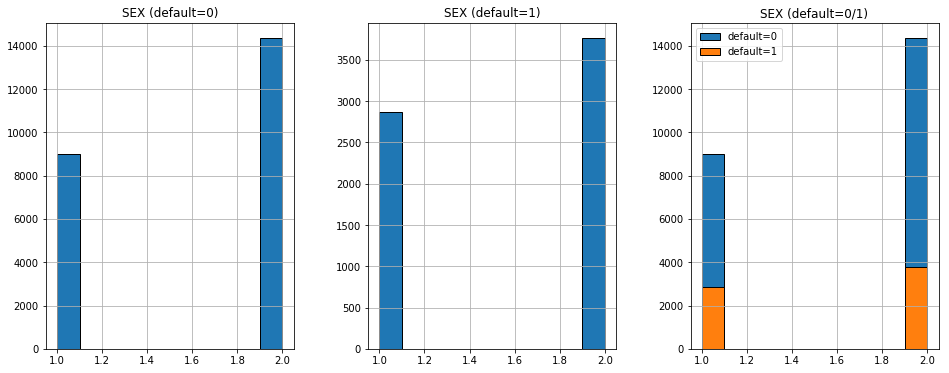

In [15]:
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 3, 1)
data_0.hist(column='SEX', edgecolor='black', ax=ax1)
ax1.set_title('SEX (default=0)')

ax2 = plt.subplot(1, 3, 2)
data_1.hist(column='SEX', edgecolor='black', ax=ax2)
ax2.set_title('SEX (default=1)')

ax3 = plt.subplot(1, 3, 3)
data_0.hist(column='SEX', edgecolor='black', ax=ax3, label='default=0')
data_1.hist(column='SEX', edgecolor='black', ax=ax3, label='default=1')
ax3.legend()
ax3.set_title('SEX (default=0/1)')

plt.show()

1 - мужчины   
2 - женщины   

По гистограмме сложно что-то сказать, можно лишь сделать предварительный вывод, что доли женщин и мужчин, которые не возвращают кредит примерно равны

**Построим таблицу сопряженности**

In [16]:
sex_table = pd.pivot_table(data, values='ID', index='SEX', columns='default', aggfunc='count')
sex_table['total'] = sex_table.sum(axis=1)
sex_table

default,0,1,total
SEX,,,
1,9015,2873,11888
2,14349,3763,18112


**Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.**

**Построим доверительные интервалы для доли мужчин среди тех, кто вернул и не вернул соответственно**

In [17]:
n1, n2 = sex_table[0].sum(), sex_table[1].sum()
p1 = sex_table.iloc[0, 0] / n1
print('Доля мужчин среди тех, кто вернул кредит:', p1)

Доля мужчин среди тех, кто вернул кредит: 0.38585002568053417


In [18]:
p2 = sex_table.iloc[0, 1] / n2
print('Доля мужчин среди тех кто, не вернул кредит:', p2)

Доля мужчин среди тех кто, не вернул кредит: 0.43294153104279687


In [55]:
from statsmodels.stats.proportion import proportion_confint
confint_0 = proportion_confint(sex_table.iloc[0, 0], n1)
confint_1 = proportion_confint(sex_table.iloc[0, 1], n2)
print('Доверительный интервал для доли мужчин среди тех, кто вернул кредит:', confint_0)
print('Доверительный интервал для доли мужчин среди тех, кто не вернул кредит:', confint_1)

Доверительный интервал для доли мужчин среди тех, кто вернул кредит: (0.37960806572767264, 0.3920919856333957)
Доверительный интервал для доли мужчин среди тех, кто не вернул кредит: (0.4210202357094044, 0.44486282637618935)


Доверительные интервалы не пересекаются, следовательно можно сделать вывод, что гендерный состав отличается.

**Построим доверительные интервалы для разности долей мужчин**

Поскольку выборки независимы, воспользуемся соответствующей формулой:

$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

Строить будем 95% доверительный интервал

In [20]:
import scipy

alpha = 0.05
z = scipy.stats.norm.ppf(1 - alpha / 2.)   

left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/n1 + p2 * (1 - p2)/n2)
right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/n1 + p2 * (1 - p2)/n2)
left_boundary, right_boundary

(-0.060548077974896725, -0.03363493274962867)

Дверительный интервал не содержит нуля, следовательно доли отличаются.   
Из данного интервала можно сделать вывод, что мужчин, которые не вернули кредит больше, чем тех, кто вернул.

**Воспользуемся теперь z-критерием для раности долей двух независимых выборок:**

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [21]:
P = (p1*n1 + p2*n2) / (n1 + n2)
z_stat = (p1 - p2)/np.sqrt(P*(1-P)*(1/n1 + 1/n2))
z_stat

-6.921375088562897

Проверим двустороннюю альтернативу, что доли не равны:

In [22]:
2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

4.472866521609831e-12

Следовательно на уровне значимости 0.05 нулевая гипотеза о том, что доли равны отвергается в пользу двусторонней альтернативы.  
Проверим теперь одностороннюю альтернативу, что доля мужчин, которые вернули кредит меньше доли тех, кто не вернул:

In [23]:
scipy.stats.norm.cdf(z_stat)

2.2364021679070564e-12

Получаем, что нулевая гипотеза также отвергается в пользу односторонней альтернативы

Проделаем аналогичные выкладки для женщин

In [24]:
p3 = sex_table.iloc[1, 0] / n1
p3

0.6141499743194658

In [25]:
p4 = sex_table.iloc[1, 1] / n2
p4

0.5670584689572031

In [26]:
alpha = 0.05
z = scipy.stats.norm.ppf(1 - alpha / 2.)   

left_boundary = (p3 - p4) - z * np.sqrt(p3 * (1 - p3)/n1 + p4 * (1 - p4)/n2)
right_boundary = (p3 - p4) + z * np.sqrt(p3 * (1 - p3)/n1 + p4 * (1 - p4)/n2)
left_boundary, right_boundary

(0.03363493274962867, 0.060548077974896725)

Доверительные интервал не содержит нуля, следовательно доли отличаются и доля женчин, которые кредит вернули больше доли не вернувших.

Проверим статистическую гипотезу о равенстве:

In [27]:
P = (p3*n1 + p4*n2) / (n1 + n2)
z_stat = (p3 - p4)/np.sqrt(P*(1-P)*(1/n1 + 1/n2))
z_stat

6.921375088562897

In [28]:
2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

4.472866521609831e-12

Следовательно нулевая гипотеза о равенстве отвергается на уровне значимости 0.05

Поскольку доли вернувших и не вернувших отличаются от 3% до 6%, то о практической значимости может судить только эксперт. Если для банка разница в 6% значительна, то данный результат будет практически значимым. 

## 3. Образование (EDUCATION).
Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

**Построим гистограмму частот**

In [29]:
import seaborn as sns

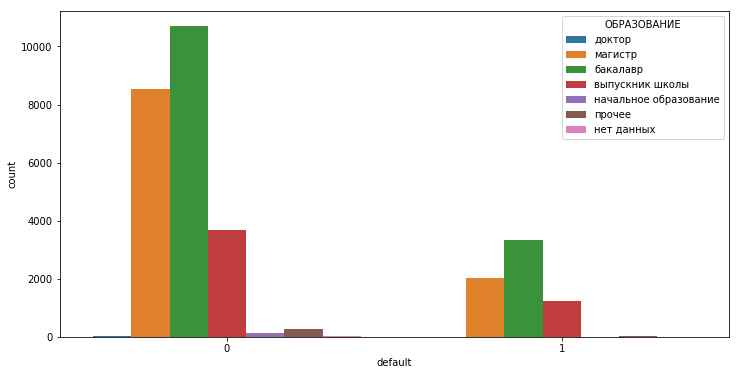

In [30]:
education = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']
plt.figure(figsize=(12, 6))
sns.countplot(x='default', data=data, hue='EDUCATION')
plt.legend(education, title='ОБРАЗОВАНИЕ')
plt.show()

По гистограмме сложно судить, поскольку распределения очень похожи.

**Построим таблицу сопряженности для исходных данных**

In [31]:
educ_def_table = pd.pivot_table(data, index='EDUCATION', columns='default', values='ID', aggfunc='count', fill_value=0)
mapper = {0: 'доктор', 1: 'магистр', 2: 'бакалавр', 3: 'выпускник школы', 4: 'начальное образование', 
          5: 'прочее', 6: 'нет данных'}
educ_def_table.rename(mapper, inplace=True)
educ_def_table['total'] = educ_def_table.sum(axis=1)
educ_def_table

default,0,1,total
EDUCATION,,,
доктор,14,0,14
магистр,8549,2036,10585
бакалавр,10700,3330,14030
выпускник школы,3680,1237,4917
начальное образование,116,7,123
прочее,262,18,280
нет данных,43,8,51


**Построим график, чтобы узнать влияет ли образование на возврат кредита**

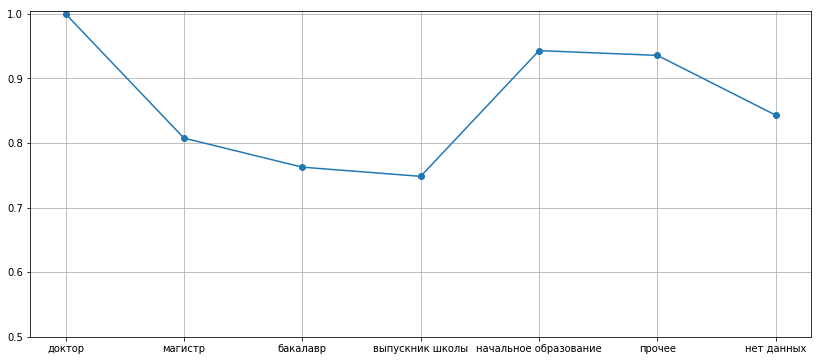

In [32]:
plt.figure(figsize=(14, 6))
plt.ylim(0.5, 1.005)
freqs = educ_def_table[0] / educ_def_table.total
plt.plot(educ_def_table.index, freqs, marker='o')
plt.grid()

Можно заметить, что распределение частот вернувших кредит получилось неравномерным, следовательно нельзя сделать вывод о том, что образование не влияет на возврат долга. Чаще всего долг возвращают люди с начальном образованием, либо с докторской степенью. Реже всего - выпускники школ. 

**Построим с помощью критерия хи-квадрат таблицу сопряженности с ожидаемым количеством человек, а также проверим гипотезу о независимости образования и дефолта**

**$H_0:$** образования и дефолт независимы  
**$H_1:$** образования и дефолт зависимы

In [33]:
from scipy.stats import chi2_contingency

In [34]:
_stat, chi2_pvalue, _dof, exp_vals = chi2_contingency(educ_def_table[[0, 1]])
print('Достигаемый уровень значимости:', chi2_pvalue)

Достигаемый уровень значимости: 1.2332626245415605e-32


Гипотеза о независимости отвергается на уровне значимости 0.05

In [35]:
expected_educ_def_table = pd.DataFrame(exp_vals, index=educ_def_table.index, 
             columns=educ_def_table.columns[:-1])
expected_educ_def_table = expected_educ_def_table.round().astype(int)
expected_educ_def_table['total'] = expected_educ_def_table.sum(axis=1)
expected_educ_def_table

default,0,1,total
EDUCATION,,,
доктор,11,3,14
магистр,8244,2341,10585
бакалавр,10927,3103,14030
выпускник школы,3829,1088,4917
начальное образование,96,27,123
прочее,218,62,280
нет данных,40,11,51


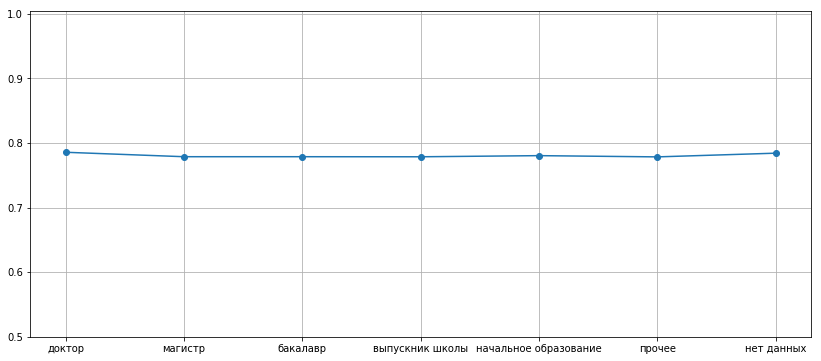

In [36]:
plt.figure(figsize=(14, 6))
plt.ylim(0.5, 1.005)
freqs = expected_educ_def_table[0] / educ_def_table.total
plt.plot(educ_def_table.index, freqs, marker='o')
plt.grid()

Видно, что распределение в этом случае равномерное

**Построим таблицу сопряженности для разности между наблюдаемыми и ожидаемыми значениями**

In [37]:
educ_def_table[[0, 1]] - expected_educ_def_table[[0, 1]]

default,0,1
EDUCATION,,
доктор,3,-3
магистр,305,-305
бакалавр,-227,227
выпускник школы,-149,149
начальное образование,20,-20
прочее,44,-44
нет данных,3,-3


**Таблица наблюдаемых и ожидаемых значений для default=0:**

In [38]:
obs_exp_table = pd.DataFrame({'observed': educ_def_table[0], 'expected': expected_educ_def_table[0], 
                              'diffrence': educ_def_table[0]-expected_educ_def_table[0]})
obs_exp_table

,observed,expected,diffrence
EDUCATION,,,
доктор,14,11,3
магистр,8549,8244,305
бакалавр,10700,10927,-227
выпускник школы,3680,3829,-149
начальное образование,116,96,20
прочее,262,218,44
нет данных,43,40,3


**Проверим гипотезу о том, что распределение неравномерное.**  

Пусть нулевая гипотеза состоит в том, что распределение равномерное (т.е. для каждого образования вероятность вернуть кредит одинакова). Альтернатива - неравномерное.   
Проверим данную гипотезу с помощью критерия хи-квадрат.

In [39]:
scipy.stats.chisquare(obs_exp_table.observed, obs_exp_table.expected, ddof=1)

Power_divergenceResult(statistic=35.888416115499076, pvalue=9.998944507848566e-07)

Получаем, что нулевая гипотеза о равномерности отвергается на уровне значимости 0.05

## 4. Семейное положение (MARRIAGE)
Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

**Построим таблицу сопряженности**

In [40]:
marr_def_table = pd.pivot_table(data, values='ID', index='MARRIAGE', columns='default', aggfunc='count')
marr_def_table.rename({0: 'отказываюсь отвечать', 1: 'замужем/женат', 2: 'холост', 3: 'нет данных'}, inplace=True)
marr_def_table['total'] = marr_def_table.sum(axis=1)
marr_def_table

default,0,1,total
MARRIAGE,,,
отказываюсь отвечать,49,5,54
замужем/женат,10453,3206,13659
холост,12623,3341,15964
нет данных,239,84,323


Поскольку данных типа "отказываюсь отвечать" и "нет данных" очень мало, а также они не несут значимой информации, то удалим их и далее будет рассматривать только признаки "замужем/женат" и "холост".

In [41]:
marr_def_table.drop(['отказываюсь отвечать', 'нет данных'], inplace=True)
marr_def_table

default,0,1,total
MARRIAGE,,,
замужем/женат,10453,3206,13659
холост,12623,3341,15964


**Для оставшихся значений признаков построим гистограмму**

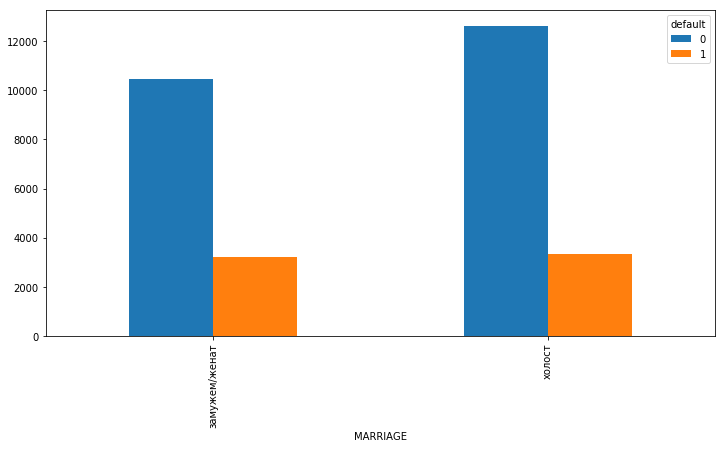

In [42]:
marr_def_table.plot.bar(y=marr_def_table.columns[:-1], figsize=(12, 6))
plt.show()

По гистограмме видно, что семейный статус не влияет на дефолт. Проверим это формально.

**Для меры взаимосвязи категориальных признаков посчитаем коэффициент V Крамера:**

In [43]:
chi2, _p, _dof, _expected = chi2_contingency(marr_def_table[[0, 1]])
np.sqrt(chi2/marr_def_table.total.sum())

0.030473764821587788

Коэффициент V Крамера получился близким у нулю, следовательно взаимосвязь между семейным статусом и дефолтом отсутствует.   
Полученный результат также будет являться и практически значимым, поскольку не иммет значения кому выдавать кредит: женатому/замужнему человеку или холостому.

## 5. Возраст (AGE) 
Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

**Построим гистограммы частот**

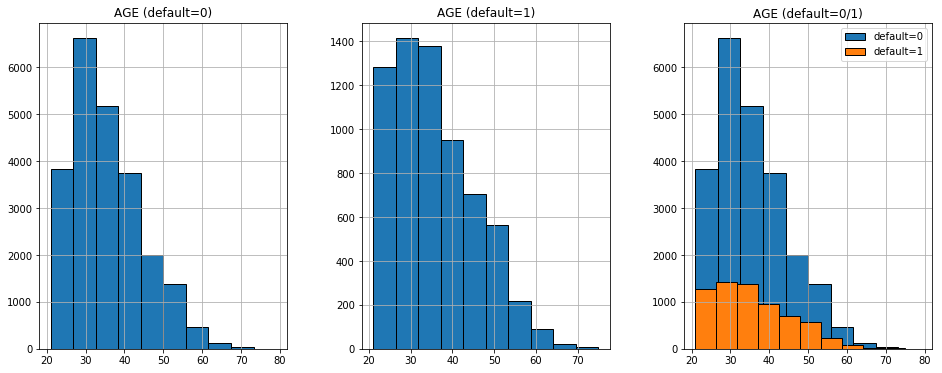

In [44]:
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 3, 1)
data_0.hist(column='AGE', edgecolor='black', ax=ax1)
ax1.set_title('AGE (default=0)')

ax2 = plt.subplot(1, 3, 2)
data_1.hist(column='AGE', edgecolor='black', ax=ax2)
ax2.set_title('AGE (default=1)')

ax3 = plt.subplot(1, 3, 3)
data_0.hist(column='AGE', edgecolor='black', ax=ax3, label='default=0')
data_1.hist(column='AGE', edgecolor='black', ax=ax3, label='default=1')
ax3.legend()
ax3.set_title('AGE (default=0/1)')

plt.show()

In [45]:
med_age_0, med_age_1 = data_0.AGE.median(), data_1.AGE.median()
print('Медиана возраста для тех, кто вернул кредит {}'.format(med_age_0))
print('Медиана возраста для тех, кто не вернул кредит {}'.format(med_age_1))

Медиана возраста для тех, кто вернул кредит 34.0
Медиана возраста для тех, кто не вернул кредит 34.0


**Построим с помощью бутстрепа 95% интервальные оценки для медиан каждого класса**

In [46]:
med_age_scores_0 = list(map(np.median, get_bootstrap_samples(data_0.AGE.values, 1000)))

In [47]:
med_age_scores_1 = list(map(np.median, get_bootstrap_samples(data_1.AGE.values, 1000)))

In [48]:
print('Доверит. интервал медианы возраста, default=0:', stat_intervals(med_age_scores_0, 0.05))
print('Доверит. интервал медианы возраста, default=1:', stat_intervals(med_age_scores_1, 0.05))

Доверит. интервал медианы возраста, default=0: [34. 34.]
Доверит. интервал медианы возраста, default=1: [34. 35.]


Доверительные интервалы пересекаются, поэтому сложно сказать различаются ли медианы.

**Построим доверительный интервал для разности медиан**

In [49]:
delta_med_age_scores = list(map(lambda x: x[0] - x[1], zip(med_age_scores_0, med_age_scores_1)))
stat_intervals(delta_med_age_scores, 0.05)

array([-1.,  0.])

Доверительный интервал содержит нуль, следовательно медианы выборок не различаются.

**Проверим гипотезу о равенстве распределений с помощью перестановочного критерия:**  

$H_0: F_{X_1}(x) = F_{X_2}(x);$  
$H_1: F_{X_1}(x) = F_{X_2}(x + \delta),  \delta <\ne> 0;$ 

где $X_1$ и $X_2$ выборки (возраста) для тех кто вернул и не вернул соответственно

In [50]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [51]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [52]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [53]:
def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [54]:
permutation_test(data_0.AGE, data_1.AGE, max_permutations=1000, alternative='two-sided')

0.015

На уровне значимости 0.05 нулевая гипотеза о равенстве распределений отвергается, следовательно распределения неодинаковы

Полученные результаты не несут практической значимости, поскольку разница медиан содержит нуль, а также смещение если и есть, то небольшое и никак не влияет вернул ли человек кредит.